In [493]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [494]:
team_records_initial = pd.read_csv('records.csv')[['year','team','team_wins','team_losses','team_ties','playoffs']]
#team_records = team_records[['year','team','team_wins','team_losses','team_ties']]
df_initial = pd.read_csv('bref.csv')

In [495]:
master_org_dict = {'MON':'WSN',
                   'CAL':'LAA',
                   'WSA':'TEX',
                   'SEP':'MIL',
                   'KCA':'OAK',
                   'MLN':'ATL',
                   'FLA':'MIA',
                   'TBD':'TBR',
                   'WSH':'MIN',
                   'NYG':'SFG',
                   'BRO':'LAD',
                   'PHA':'OAK',
                   'SLB':'BAL',
                   'BSN':'ATL',
                   'ANA':'LAA'
                  }

recs = team_records_initial.copy()
recs['master_team'] = recs['team'].apply(lambda x: master_org_dict[x] if x in master_org_dict else x)
recs2 = recs.copy()
for col in ['team_wins','team_losses','team_ties']:
    recs2 = recs2.rename(columns={col:'%s_prior_year' % col})
recs2['year'] = recs2['year'] + 1
    
recs = pd.merge(recs,recs2,on=['year','team','playoffs','master_team'],how='left')

In [496]:
def adjust_data_frame(data_frame):
    for val in ['','_prior_year']:
        win_col = 'team_wins%s' % val
        loss_col = 'team_losses%s' % val
        tie_col = 'team_ties%s' % val
        
        data_frame['team_games_played%s' % val] = data_frame[win_col] + data_frame[loss_col] + data_frame[tie_col]
        data_frame['team_win_pct%s' % val] = data_frame[win_col] / (data_frame[loss_col] + data_frame[win_col])
    data_frame['decade'] = data_frame['year'].apply(lambda x: str(x)[:3] + '0s')
    for col in ['wins','saves']:
        data_frame[col] = data_frame[col].fillna(0)
    data_frame['wins_saves'] = data_frame['wins'] + data_frame['saves']
    data_frame = data_frame.loc[data_frame.voting_place<=20,:]
    data_frame = data_frame.loc[data_frame.wins_saves==0,:]
    data_frame['wins_improvement'] = data_frame['team_wins'] + data_frame['team_wins_prior_year']
    data_frame['win_pct_improvement'] = data_frame['team_win_pct'] + data_frame['team_win_pct_prior_year']
    data_frame['runs_produced'] = data_frame['runs'] + data_frame['rbi'] - data_frame['home_runs']
    return data_frame

In [497]:
df = df_initial.copy()
df = pd.merge(df,recs,on=['team','year'],how='left')
df = adjust_data_frame(df)
#df = df.sort_values(['year','league','points'],ascending=False).reset_index()
max_year_df = df[['year','league','voting_place']].groupby(['year','league']).min().reset_index()
max_year_df = max_year_df.rename(columns={'voting_place':'max_finish'})
df = pd.merge(df,max_year_df,on=['year','league'],how='left')
df['winner'] = df['max_finish'] == df['voting_place']

In [499]:
group_cols = ['year','league']
stats = ['war','rbi','runs','home_runs','team_wins','average','obp','slg','ops','sb','team_win_pct','win_pct_improvement','wins_improvement','runs_produced']
max_df = df[group_cols + stats].groupby(group_cols).max().reset_index()

for val in stats:
    max_df = max_df.rename(columns={val:'max_%s'%val})
    
df = pd.merge(df,max_df,on=['year','league'],how='left')
for col in stats:
    df['%s_difference' % col] = df[col] - df['max_%s' % col]

In [500]:
league_leaders_df = pd.DataFrame()

for stat in stats:
    temp = df.loc[df['%s_difference' % stat]==0][['year','decade','league','voting_place']]
    temp['metric'] = stat
    league_leaders_df = pd.concat([league_leaders_df,temp])
    
league_leaders_df = league_leaders_df.groupby(['year','decade','league','metric']).min().reset_index()

In [501]:
stats = ['average','home_runs','rbi','runs','sb','obp','ops','slg','war','runs_produced']

In [502]:
group_cols = ['decade','voting_place']
grouped_df = df[group_cols + stats].groupby(group_cols).mean().reset_index()

In [503]:
grouped_df.head()

,decade,voting_place,average,home_runs,rbi,runs,sb,obp,ops,slg,war,runs_produced
0,1950s,1,0.314824,33.470588,114.117647,102.352941,5.235294,0.395941,0.959941,0.564000,7.529412,183.000000
1,1950s,2,0.323133,31.066667,105.866667,104.200000,8.200000,0.409533,0.976067,0.566667,7.060000,179.000000
2,1950s,3,0.318500,27.562500,100.937500,105.125000,6.500000,0.393750,0.931125,0.537500,6.762500,178.500000
3,1950s,4,0.315765,25.529412,99.058824,102.823529,11.117647,0.396059,0.935118,0.539000,6.164706,176.352941
4,1950s,5,0.307875,25.750000,82.375000,102.500000,8.125000,0.401750,0.924125,0.522625,6.412500,159.125000


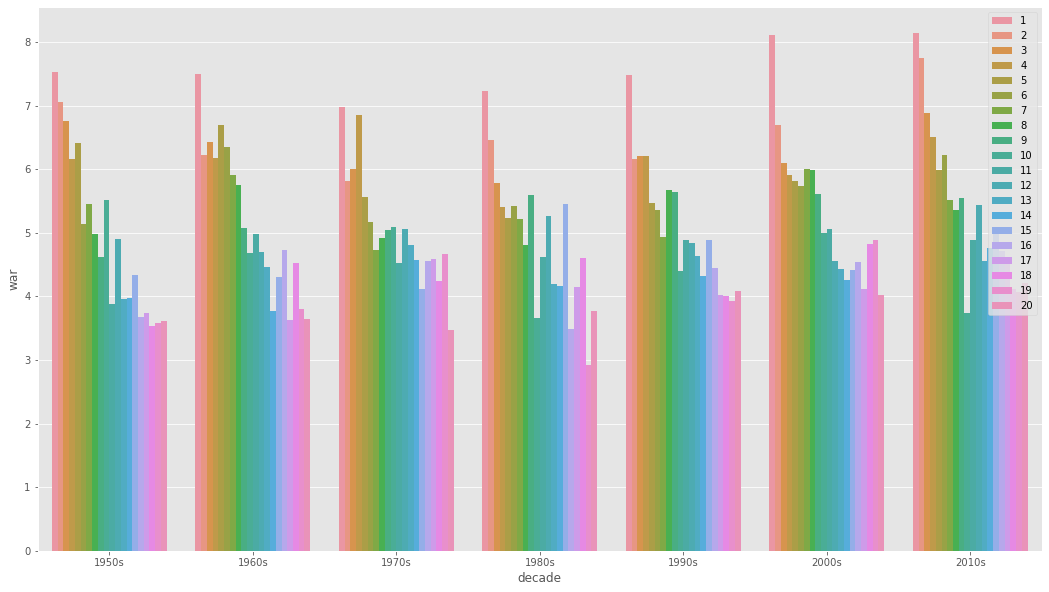

In [454]:
plt.figure(figsize=(18,10))
sns.barplot(x='decade', y='war', data=grouped_df, hue="voting_place")
plt.legend(loc='upper right')

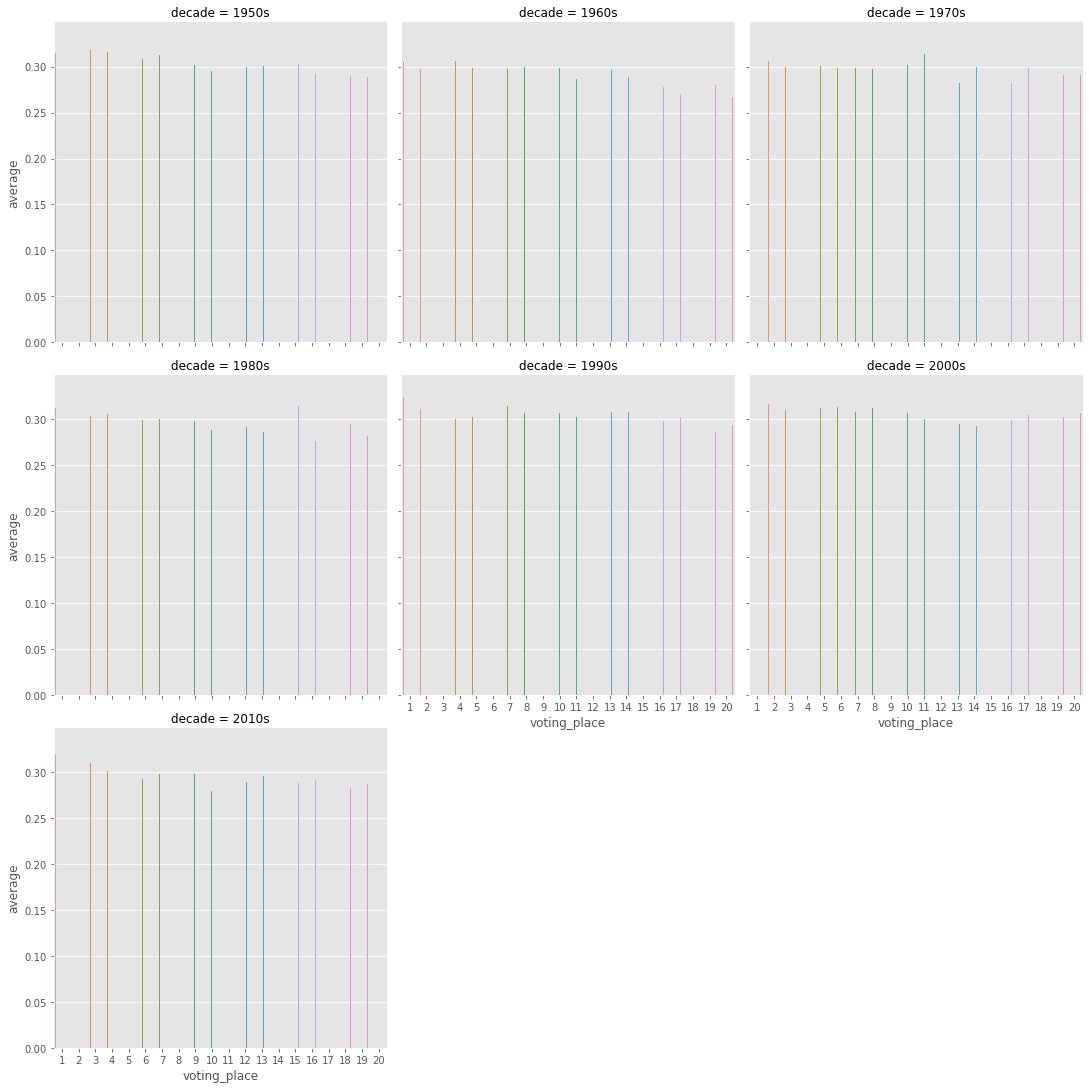

In [455]:
sns.catplot(x='voting_place', y='average', kind='bar', data=grouped_df, hue="voting_place",col='decade',col_wrap=3)

<AxesSubplot:xlabel='year', ylabel='home_runs'>

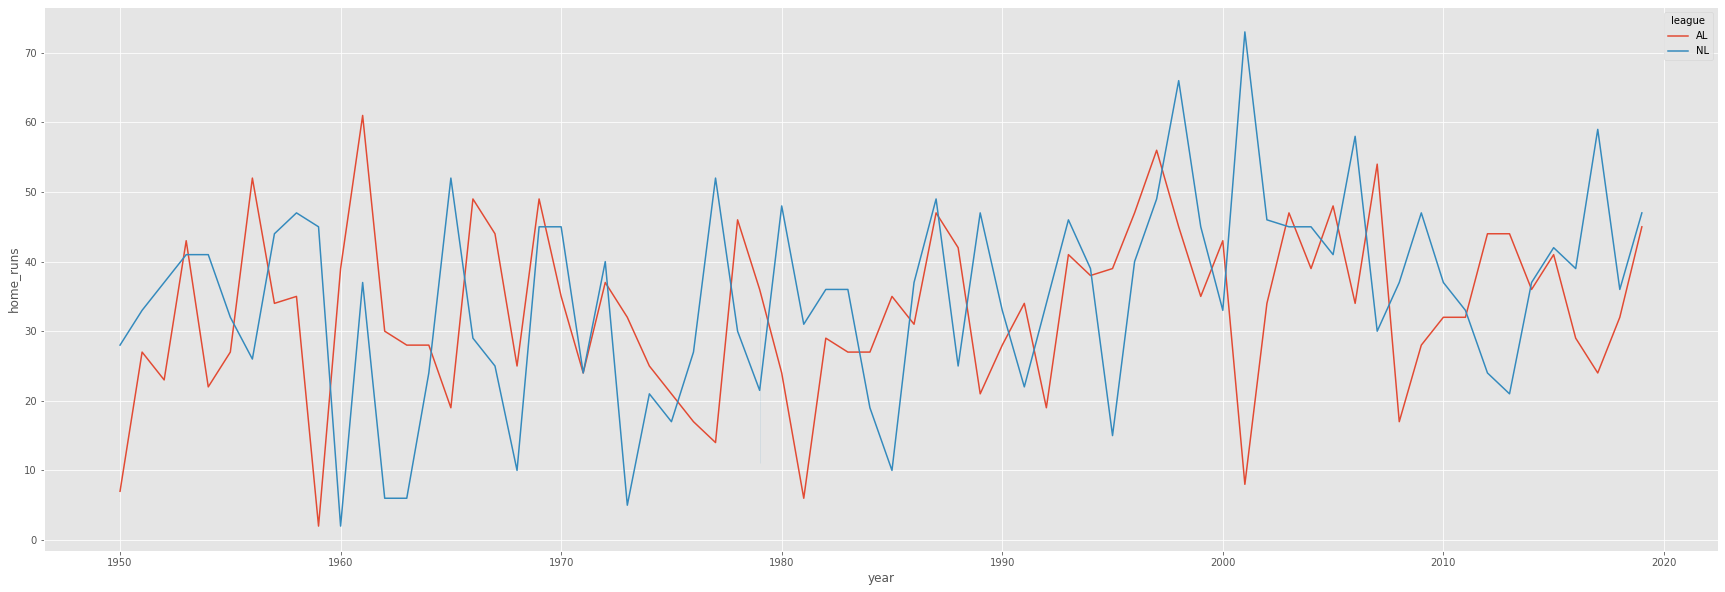

In [443]:
plt.figure(figsize=(30,10))
sns.lineplot(x='year', y='home_runs', data=df.loc[df.winner==True],hue='league')

In [556]:
group_cols = ['decade','playoffs','winner']
grouped_df = df[group_cols + stats + ['war_difference','home_runs_difference','rbi_difference']].groupby(group_cols).mean().reset_index()

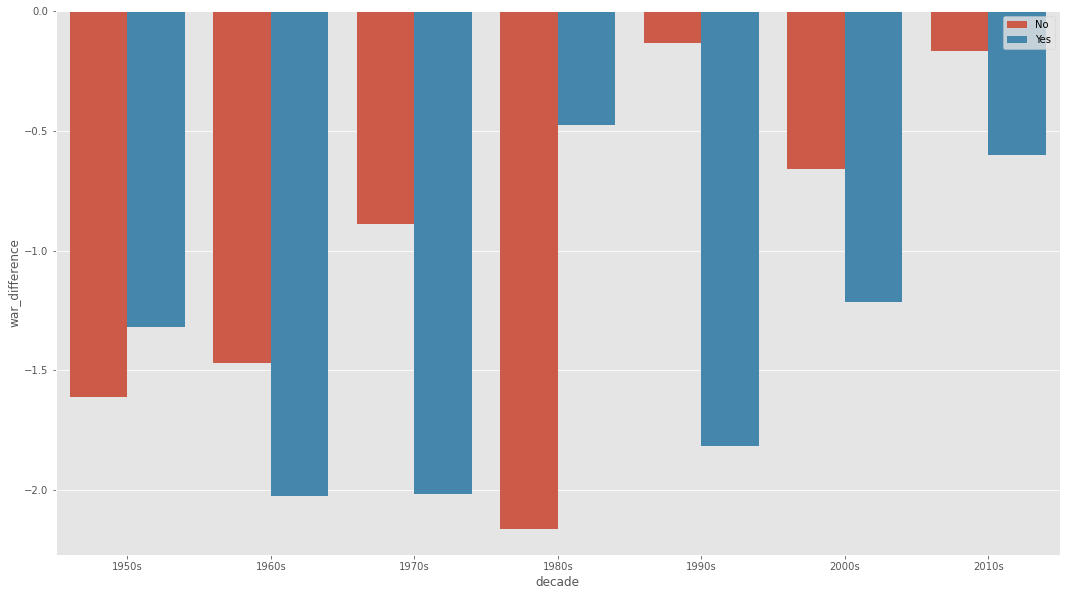

In [557]:
plt.figure(figsize=(18,10))
sns.barplot(x='decade', y='war_difference', data=grouped_df.loc[grouped_df.winner==True], hue="playoffs")
plt.legend(loc='upper right')

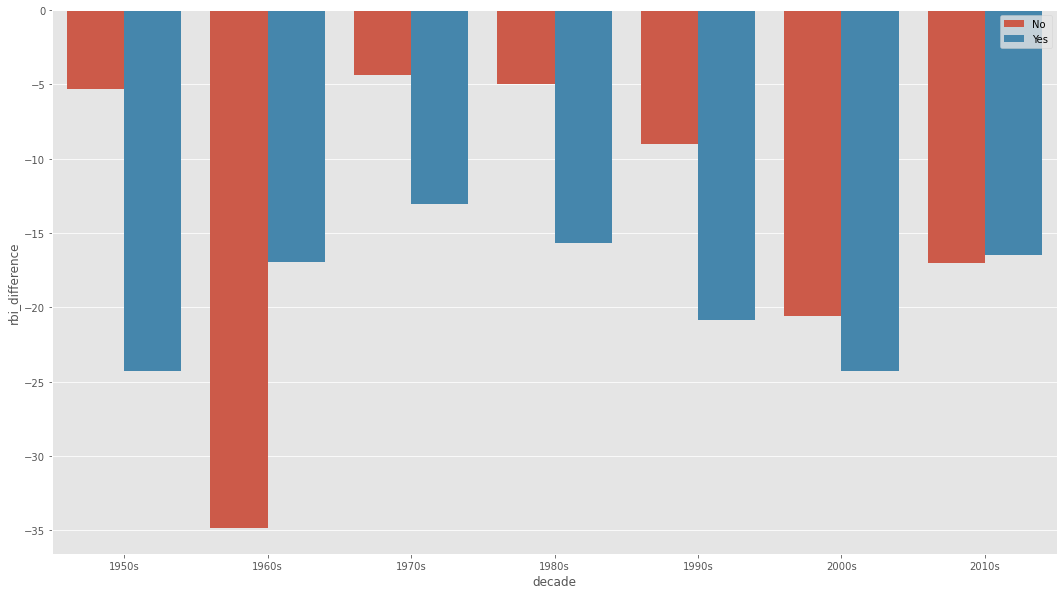

In [559]:
plt.figure(figsize=(18,10))
sns.barplot(x='decade', y='rbi_difference', data=grouped_df.loc[grouped_df.winner==True], hue="playoffs")
plt.legend(loc='upper right')

In [548]:
test = df[df['decade']=='1980s']
test = test[test['winner']==True]

In [549]:
test[['war_difference','year','name','playoffs']]

,war_difference,year,name,playoffs
0,0.0,1983,"Ripken,Cal",Yes
16,-0.3,1983,"Murphy,Dale",No
31,0.0,1982,"Yount,Robin",Yes
50,-2.5,1982,"Murphy,Dale",Yes
65,0.0,1981,"Henderson,Rickey",Yes
81,0.0,1981,"Schmidt,Mike",Yes
96,0.0,1980,"Brett,George",Yes
112,0.0,1980,"Schmidt,Mike",Yes
1514,-2.9,1989,"Yount,Robin",No
1528,-1.9,1989,"Mitchell,Kevin",Yes


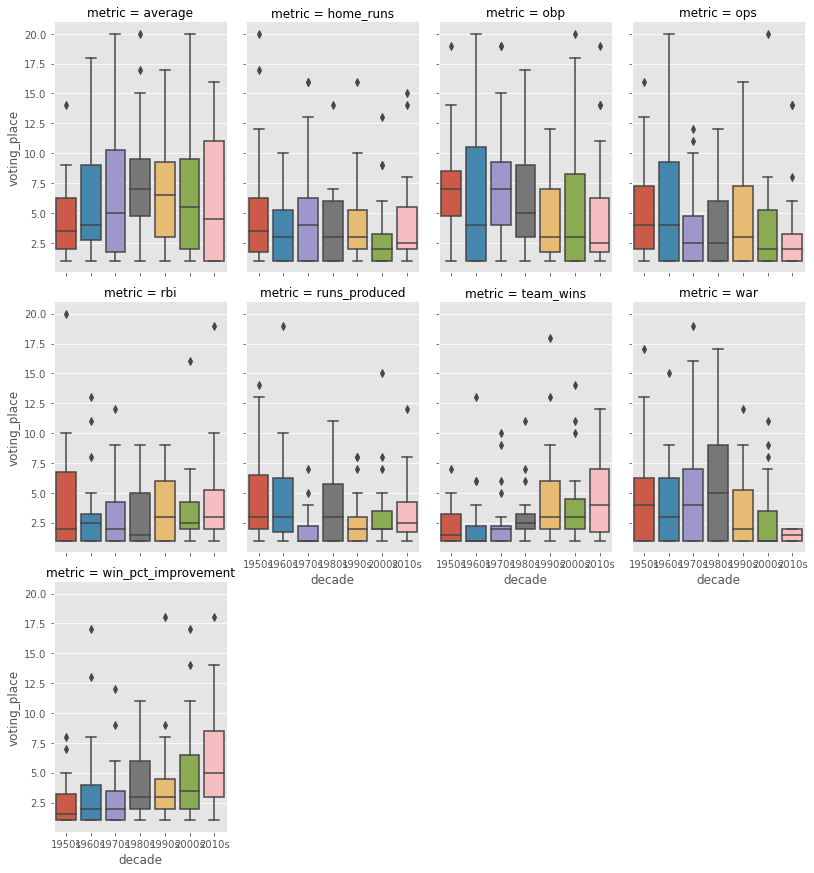

In [434]:
sns.catplot(x="decade", y="voting_place",
                 col="metric",
                data=league_leaders_df[league_leaders_df['metric'].isin(['average','home_runs','rbi','runs_produced','obp','ops','war','team_wins','win_pct_improvement'])], kind="box",col_wrap=4,
                height=4, aspect=.7)

In [426]:
league_leaders_df['metric'].unique()

array(['average', 'home_runs', 'obp', 'ops', 'rbi', 'runs',
       'runs_produced', 'sb', 'slg', 'team_win_pct', 'team_wins', 'war',
       'win_pct_improvement', 'wins_improvement'], dtype=object)